In [3]:
# !pip install wordcloud
# !pip install nltk
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')

import pandas as pd 
import numpy as np 
import time

#For Text Cleaning
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')


#For text vectorizing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora
from gensim import models
import random



# Emotion Analysis 
import text2emotion as te

# pos tagging 
from collections import Counter

# ploting 
import seaborn as sn
import matplotlib.pyplot as plt

# VADER generation 
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Clement\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Clement\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Clement\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# for preprocessing

# Function to clean the compiled dataframe
def preprocess(review):
    review = " ".join([stemmer.stem(w.lower()) for w in word_tokenize(review) if not w in stop_words and re.search('^[a-z]+$',w)])
    return review

def emotion_detection(sents):
    """Main algo for convertion for the 5 emotions """
    sent_emotion = te.get_emotion(sents)
    return sent_emotion
    

# Emotion Analysis 
- Text 2 Emotion Library 
- 14000 words labelled with emotions to create the distribution of values across the 5 emotions

In [5]:
# Generating the Emotions 
def generate_emotions(news_dup):
    
    """Use to generate the dataframe that appends the orginal text and the emotion label vector"""
    
    emotion_list = []
    for i, row in news_dup.iterrows():
        emotion_dict = emotion_detection(row[2])
        emotion_dict['text'] = row[2]
        emotion_dict['label'] = row[3]
        emotion_list.append(emotion_dict)
        
        
    emotion_df = pd.DataFrame(emotion_list)
    horizontal_stack = news_dup.merge(emotion_df, how='left', on='text')
    horizontal_stack.drop(['index'], inplace=True, axis=1)       
            
    return horizontal_stack

# Sentiment Analysis using Nltk sentiment vader library 
- Identify the document sentiment across positive , negative and neutral 

In [6]:

# generating Vader https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
def vader_score_generation(emo_pos_df):
    
    """Generates the vader scores for the dataframe to create neu pos neg tags base on the text """
    sid = SentimentIntensityAnalyzer()
    polarity_Score = emo_pos_df['text'].apply(lambda review: sid.polarity_scores(review))
    df_p_scores = polarity_Score.apply(pd.Series).reset_index() # generating the scores and appending it the dataframe end 
    emo_pos_dist_pscore =  emo_pos_df.merge(df_p_scores, left_on='index', right_on='index')
    return emo_pos_dist_pscore

def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros




# POS TAG Features

- Not all pos tags exist in all the documents

In [7]:

def group_pos_features(pos_tagged_df):
    
    """This function takes in the POS feature dataframe and group POS tags together.
      Comments means that the POS tags in this data set is not prevelant as they either are not present or contain too much missing values

      Unpresent POS tags  for now it is known to be insignificant as mentioned in the research paper :
          pos_tagged_df['group_e'] = pos_tagged_df['EX']
          pos_tagged_df['NR'] + pos_tagged_df['NPS']
          pos_tagged_df['group_p'] = pos_tagged_df['PDT'] + pos_tagged_df['POS'] + pos_tagged_df['PP']
          pos_tagged_df['group_t'] = pos_tagged_df['TO']
          pos_tagged_df['group_u'] = pos_tagged_df['UH'] 
          pos_tagged_df['group_w'] = pos_tagged_df['WDT'] + pos_tagged_df['WP'] + pos_tagged_df['WP$'] + pos_tagged_df['WRB']
          # Could be a future work to include using different POS tagging dictionaries
     """ 
    #pos_group = ['group_c','group_d','group_f','group_i','group_j','group_m','group_n','group_r','group_v']
    pos_list = ['CC','CD','DT','FW','IN','JJ','JJR','JJS','MD','NN', 'NNS', 'RBR','RB','VB','VBD', 'VBN','VBP','VBZ']
    delete_pos_list = []
    pos_dict = {}
    for pos_l in pos_list:
      
      if pos_l in pos_tagged_df.columns:
        pos_dict[pos_l] = np.array(list(pos_tagged_df[pos_l]))
        delete_pos_list.append(pos_l)
      else:
        pos_dict[pos_l] = list(zerolistmaker(len(pos_tagged_df)))
      
    #print(np.sum([pos_dict['CC'],pos_dict['CD']] , axis=0))
    pos_tagged_df['group_c'] = np.sum([pos_dict['CC'],pos_dict['CD']], axis=0) 
    pos_tagged_df['group_d'] = pos_dict['DT'] 
    pos_tagged_df['group_f'] = pos_dict['FW'] 
    pos_tagged_df['group_i'] = pos_dict['IN']
    pos_tagged_df['group_j'] = np.sum([pos_dict['JJ'],pos_dict['JJR'], pos_dict['JJS']], axis=0)  
    
    pos_tagged_df['group_m'] = pos_dict['MD']
    pos_tagged_df['group_n'] = np.sum([pos_dict['NN'],pos_dict['NNS']], axis=0) 
    
    # changed RBP to RBR 
    pos_tagged_df['group_r'] = np.sum([pos_dict['RBR'],pos_dict['RB']], axis=0) 
    pos_tagged_df['group_v'] =  np.sum([pos_dict['VB'],pos_dict['VBD'], pos_dict['VBN'],  pos_dict['VBP'],  pos_dict['VBZ']], axis=0)  

    return pos_tagged_df, delete_pos_list


def generate_pos_tag_dist(df):
    
    """Takes in a df : this dataframe contains the emotions,
        and outputs the dataframe with additional pos tags above that have no more than 30% missing """
        
    emotion_text = list(df['text'])
    counts = []
    for sentences in emotion_text:
        tokens = nltk.word_tokenize(sentences)    
        tags = nltk.pos_tag(tokens)
        counts.append(Counter( tag for word,  tag in tags))

    # creating the pos count feature and setting non rare pos tag features ,
    df_post_dist = pd.DataFrame.from_records(counts)
    df_post_dist_non_null = df_post_dist.loc[:,df_post_dist.columns[df_post_dist.isnull().mean() < 0.7]].reset_index()
    df_post_dist_non_null.fillna(0,inplace=True)
    
    # combining the dataframe 
    return df_post_dist_non_null


# Feature Generation 

In [21]:
# Data Reading and Cleaning 
maindf = pd.read_excel('next_100.xlsx')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
#The bottom two lines will remove all stop words and stem the column text, takes very long do not run
maindf['text'] = maindf.apply(lambda x: preprocess(x['text']), axis=1)
#Export the new cleaned data into excel file
maindf.to_excel(r'next_200.xlsx', index = False, header=True)

## Emotion Feature Generation 

In [22]:
news  = pd.read_excel('next_200.xlsx')
news_dup = news.copy()
emp_df = generate_emotions(news_dup)
emp_df.to_excel('emotion_analysis_final.xlsx')

## Pos tag and Sentiment Feature Generation 

Run from here for 20k : Do not run this below cell if ran 

In [14]:
emp_df = pd.read_excel('emotion_analysis_final.xlsx')

# Generating the POS tag dist 
emo_pos_df = generate_pos_tag_dist(emp_df)
emp_df = emp_df.reset_index()
emp_df = emp_df[emp_df.columns.drop(list(emp_df.filter(regex='index')))]
emp_df = emp_df.rename(columns={emp_df.columns[0]: 'index'})
comb_emo_pos_dist =  emp_df.merge(emo_pos_df, left_on='index', right_on='index')

# genrating vader text 
emo_pos_dist_pscore = vader_score_generation(comb_emo_pos_dist)
emo_pos_dist_pscore.to_excel('emo_pos_dist_pscore.xlsx')


## Processing for plots

Below cell will take a min

In [15]:
# Generating of Pos Grouping Features 
emotional_df_stack = pd.read_excel('emo_pos_dist_pscore.xlsx')
del emotional_df_stack['compound']

emotional_df_stack_groupped_pos, pos_tags = group_pos_features(emotional_df_stack)
emotional_df_stack_groupped_pos = emotional_df_stack_groupped_pos.loc[:, (emotional_df_stack_groupped_pos != 0).any(axis=0)]
emotional_df_stack_groupped_pos.to_excel('pos_groupings_vader_emotion.xlsx')


# Visualisation 

## Principle Component Analysis
- Fake news is hard to distinguish from Real

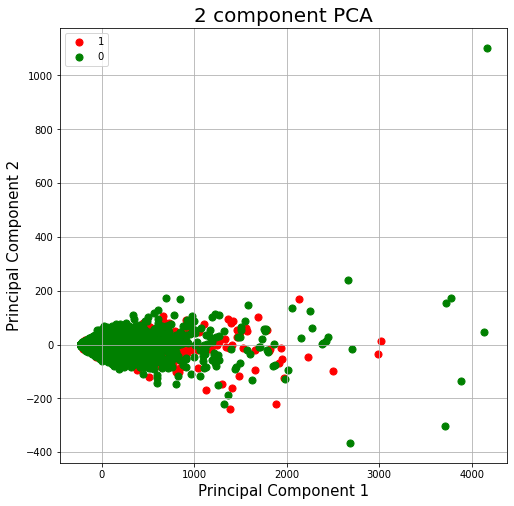

In [16]:
# PCA 
from sklearn.decomposition import PCA
emotional_df_stack = pd.read_excel('pos_groupings_vader_emotion.xlsx')
news_pca = emotional_df_stack.iloc[:, 5:]

pca = PCA(n_components=2)
news_pca_components = pca.fit_transform(news_pca)
principalDf = pd.DataFrame(data = news_pca_components, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, news_pca[['label']]], axis = 1) 

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Covariance Between Sentiment and Emotions
 - Understand if there is active multi - colinearity 

In [17]:
# Printing Corrvariance value 
corr_sentiment_emotion = pd.read_excel('sentiment_emotion_corr.xlsx')
c = corr_sentiment_emotion.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
print(so[:-14])

compound  index       0.001940
index     compound    0.001940
          label_y     0.002819
label_y   index       0.002819
index     Sad         0.002897
                        ...   
compound  pos         0.533407
pos       compound    0.533407
neu       pos         0.587556
pos       neu         0.587556
compound  neg         0.650321
Length: 107, dtype: float64


<AxesSubplot:>

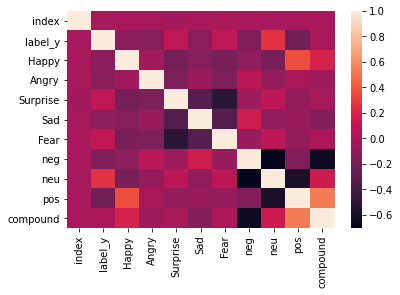

In [18]:
# Covariance heatmap 
cov_mat = corr_sentiment_emotion.corr()
# plot the heatmap
sn.heatmap(cov_mat, 
        xticklabels=cov_mat.columns,
        yticklabels=cov_mat.columns)

## Distribution of Fake and Real news by emotion  
- Fake news have higher levels of negative emotions 

<AxesSubplot:xlabel='label'>

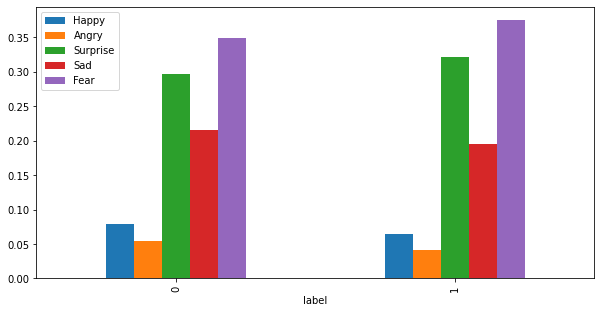

In [19]:
# Bar charts 

# generating distribution for emotions 
# Distribution of label by emotion 
plotting_df_emotion_senti_pso = emotional_df_stack.iloc[:, 4:]
plotting_df_emotion_senti_pso.groupby('label').mean().reset_index().plot(figsize=(10, 5),x="label", y=["Happy", "Angry", "Surprise", "Sad", "Fear"], kind="bar")



## Distribution of POS Tags for Real and Fake News
- Problem : Large number of Features and mostly are empty > makes the data sparse

<AxesSubplot:xlabel='label'>

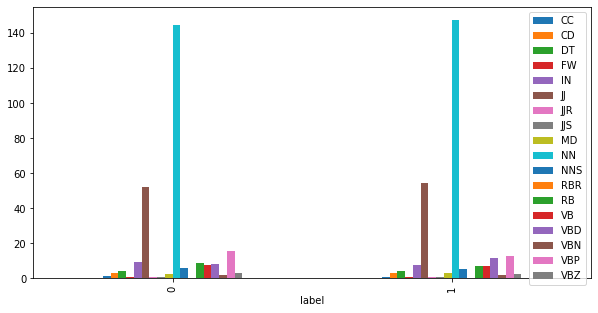

In [20]:
# generating the distribution for POS tags
plotting_df_emotion_senti_pso.groupby('label').mean().reset_index().plot(figsize=(10, 5),x="label", y=list(pos_tags), kind="bar")

### POS TAG GROUPS Distribution for Real and Fake News

- Pos Groups reduce the features and sparsity of the dataset 

<AxesSubplot:xlabel='label'>

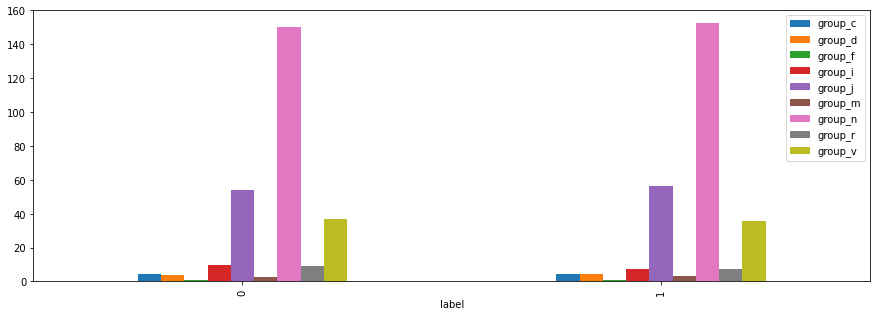

In [21]:
# generating the distribution for Vader tags
pos_groups_dist = emotional_df_stack.columns[-9:]
emotional_df_stack.groupby('label').mean().reset_index().plot(figsize=(15, 5), x="label", y=pos_groups_dist, kind="bar")

## Distribution of Sentiments for Real and Fake News

- Fake news have less netural tone in news , mostly take more stand in either being more positive or negative

<AxesSubplot:xlabel='label'>

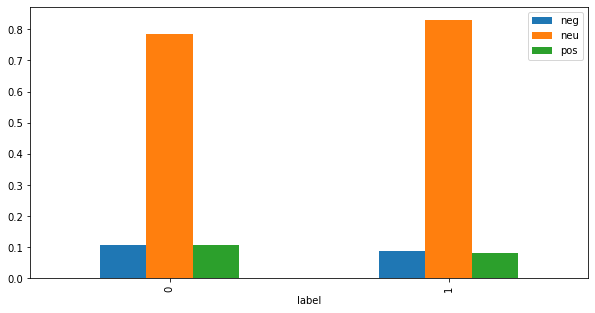

In [22]:
# generating the distribution for Vader tags
vader_tags = ['neg','neu','pos']
plotting_df_emotion_senti_pso.groupby('label').mean().reset_index().plot(figsize=(10, 5), x="label", y=vader_tags, kind="bar")

# Output file

Do not run unless its done 

In [44]:
emotional_df_stack.drop(columns=pos_tags, inplace=True)
emotional_df_stack = emotional_df_stack.loc[:, (emotional_df_stack != 0).any(axis=0)]
emotional_df_stack.to_excel('pos_groupings_vader_emotion_final.xlsx')

In [24]:
print(pos_tags)
print(pos_groups_dist)
print(vader_tags)

['CC', 'CD', 'DT', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'RBR', 'RB', 'VB', 'VBD', 'VBN', 'VBP', 'VBZ']
Index(['group_c', 'group_d', 'group_f', 'group_i', 'group_j', 'group_m',
       'group_n', 'group_r', 'group_v'],
      dtype='object')
['neg', 'neu', 'pos']
